<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/355_mcmc_diagnostics.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(diagnostics_mcmc_notebook)=
# Diagnostica delle catene markoviane

Le catene di Markov forniscono un'approssimazione che tende a convergere alla distribuzione a posteriori. "Approssimazione" e "convergenza" sono le parole chiave: il punto è che il campionamento MCMC non è perfetto. Questo solleva le seguenti domande:

-   A cosa corrisponde, dal punto di vista grafico, una "buona" catena di Markov?
-   Come possiamo sapere se il campione prodotto dalla catena di Markov costituisce un'approssimazione adeguata della distribuzione a posteriori?
-   Quanto deve essere grande la dimensione del campione casuale prodotto dalla catena Markov?

Rispondere a queste ed altre domande di questo tipo fa parte di quell'insieme di pratiche che vanno sotto il nome di *diagnostica delle catene Markoviane*.

La diagnostica delle catene Markoviane non è "una scienza esatta". Ovvero, non sono disponibili procedure che risultano valide in tutti i casi possibili e non sempre è possibile rispondere a tutte le precedenti domande. È piuttosto l'esperienza del ricercatore che consente di riconoscere una "buona" catena di Markov e a suggerire cosa si può fare per riparare una "cattiva" catena di Markov. In questo Capitolo ci concentreremo su alcuni strumenti diagnostici grafici e numerici che possono essere utilizzati per la diagnostica delle catene markoviane. L'utilizzo di questi strumenti diagnostici deve essere eseguito in modo olistico. Nessuna singola diagnostica visiva o numerica è sufficiente: un quadro completo della qualità della catena di Markov si può solo ottenere considerando tutti gli strumenti descritti di seguito.

In [1]:
from scipy import stats
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from scipy.constants import golden
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Esame dei *trace plot*

La convergenza e il "mixing" possono essere controllate mediante il *trace plot* che mostra l'andamento delle simulazioni e ci dice se stiamo effettivamente utilizzando una distribuzione limite. In generale, cerchiamo un grafico che mostri una dispersione casuale attorno a un valore medio: in tali circostanze i risultati del modello suggeriscono che le catene si mescolano bene e che le impostazioni della MCMC sono adeguate. Utilizzando il codice di {cite:t}`martin2022bayesian` presento qui degli esempi di buone e di cattive catene MCMC.

In [3]:
good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = np.random.normal(
    np.sort(good_chains, axis=None), 0.05, size=4000
).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i % 2 :, i : i + 100] = np.random.beta(i, 950, size=100)

chains = {
    "good_chains": good_chains,
    "bad_chains0": bad_chains0,
    "bad_chains1": bad_chains1,
}

array([[<AxesSubplot: title={'center': 'good_chains'}>,
        <AxesSubplot: title={'center': 'good_chains'}>],
       [<AxesSubplot: title={'center': 'bad_chains0'}>,
        <AxesSubplot: title={'center': 'bad_chains0'}>],
       [<AxesSubplot: title={'center': 'bad_chains1'}>,
        <AxesSubplot: title={'center': 'bad_chains1'}>]], dtype=object)

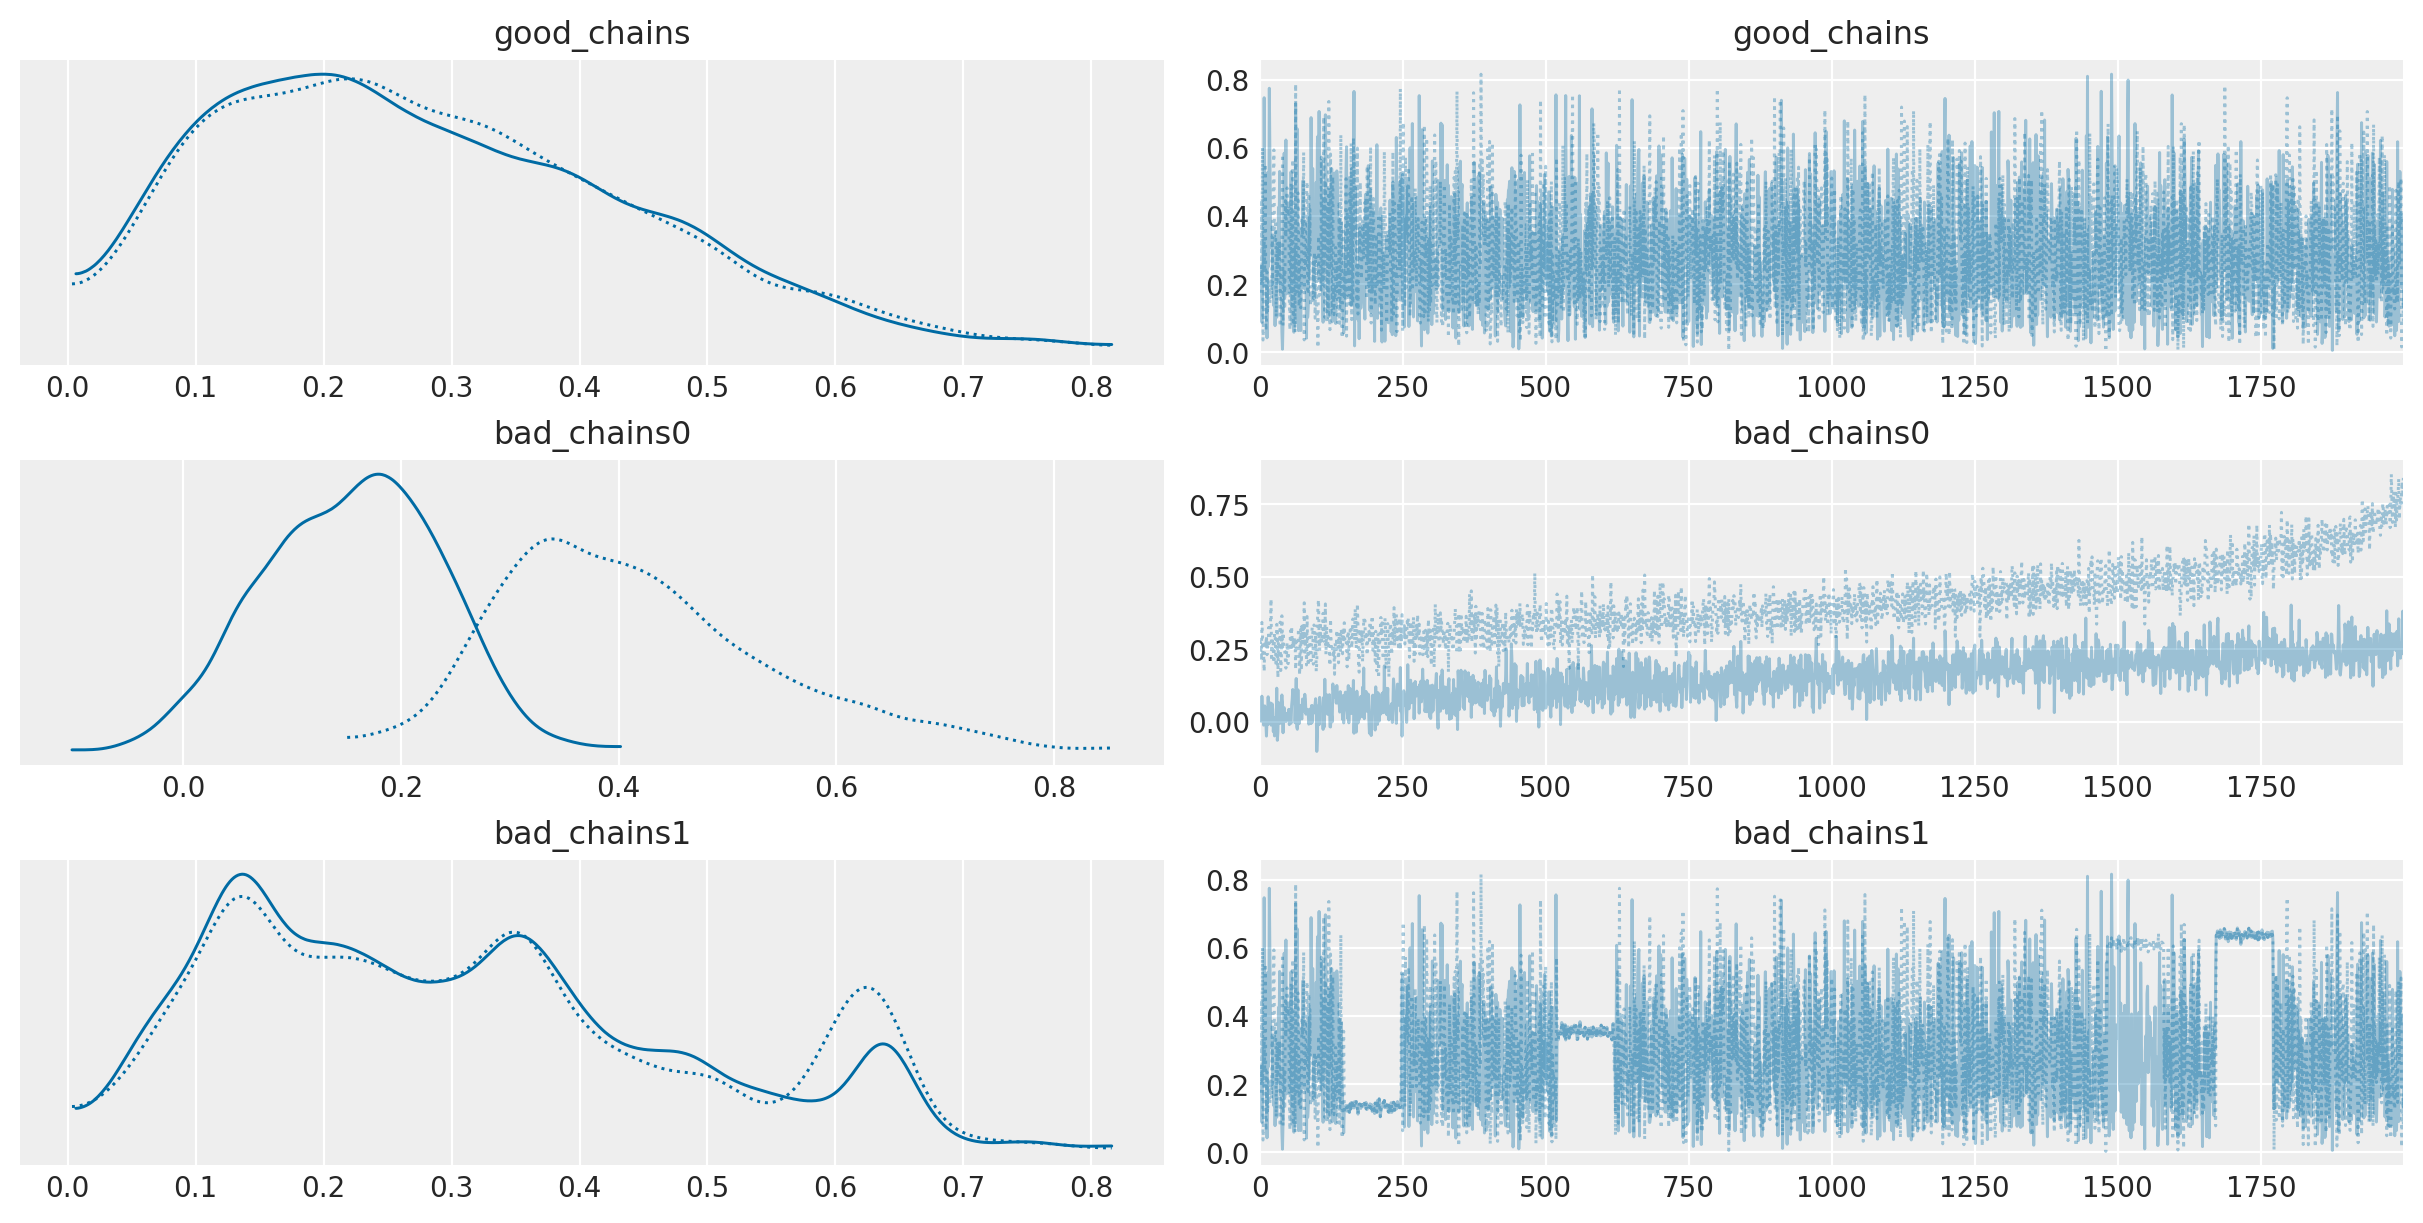

In [6]:
_ = az.plot_trace(chains)
plt.tight_layout()

Le cattive catene non convergono né si mescolano tra loro. Uno dei motivi per l'esecuzione di più catene è che ogni singola catena potrebbe convergere verso un target, mentre un'altra catena potrebbe convergere su un target diverso, e questo sarebbe un problema. Inoltre, catene altrimenti sane possono bloccarsi occasionalmente nel corso della serie, il che suggerirebbe la necessità di modifiche al modello o alle impostazioni del campionatore. Un altro modo per valutare la convergenza dell'algoritmo è plottando la densità della distribuzione a posteriori degli effetti stimati, per assicurarsi che si avvicini ad una classica curva a campana. 

In pratica, non abbiamo mai il privilegio di poter confrontare i risultati del campionamento MCMC con la corretta distribuzione a posteriori. Ecco perché la diagnostica delle catene di Markov è così importante: se vediamo trace-plots come le precedenti "bad chains", sappiamo che non abbiamo ottenuto una approssimazione adeguata della distribuzione a posteriori. In tali circostanze possiamo ricorrere ad alcuni rimedi.

1.  Controllare il modello. Siamo sicuri che le distribuzioni a priori e la verosimiglianza siano appropriate per i dati osservati?
2.  Utilizzare un numero maggiore di iterazioni. Alcune tendenze indesiderate a breve termine della catena possono appianarsi nel lungo termine.

## Numerosità campionaria effettiva

Nel campionamento si ottengono $n$ campioni *dipendenti* dei parametri $\theta$. Sapendo che l'errore dell'approssimazione alla distribuzione a posteriori è probabilmente più grande di quello che si otterrebbe usando $n$ campioni *indipendenti*, ci possiamo chiedere: quanti campioni indipendenti sarebbero necessari per produrre un'approssimazione della distribuzione a posteriori equivalentemente a quella che abbiamo ottenuto? La numerosità campionaria effettiva (*effective sample size*, $N_{eff}$) fornisce una risposta a questa domanda.

Tipicamente, $N_{eff} < N$, per cui il rapporto campionario effettivo (*effective sample size ratio*) $\frac{N_{eff}}{N}$ è minore di 1. Come regola euristica, viene considerato problematico un rapporto campionario effettivo minore del 10% del numero totale di campioni ottenuti nella simulazione (più basso è il rapporto campionario effettivo peggiore è il "mixing" della catena).

Usando nuovamente un esempio di {cite:t}`martin2022bayesian`, distinguiamo, usando la statistica ESS, tra buone e cattive catene MCMC.

(-100.0, 5000.0)

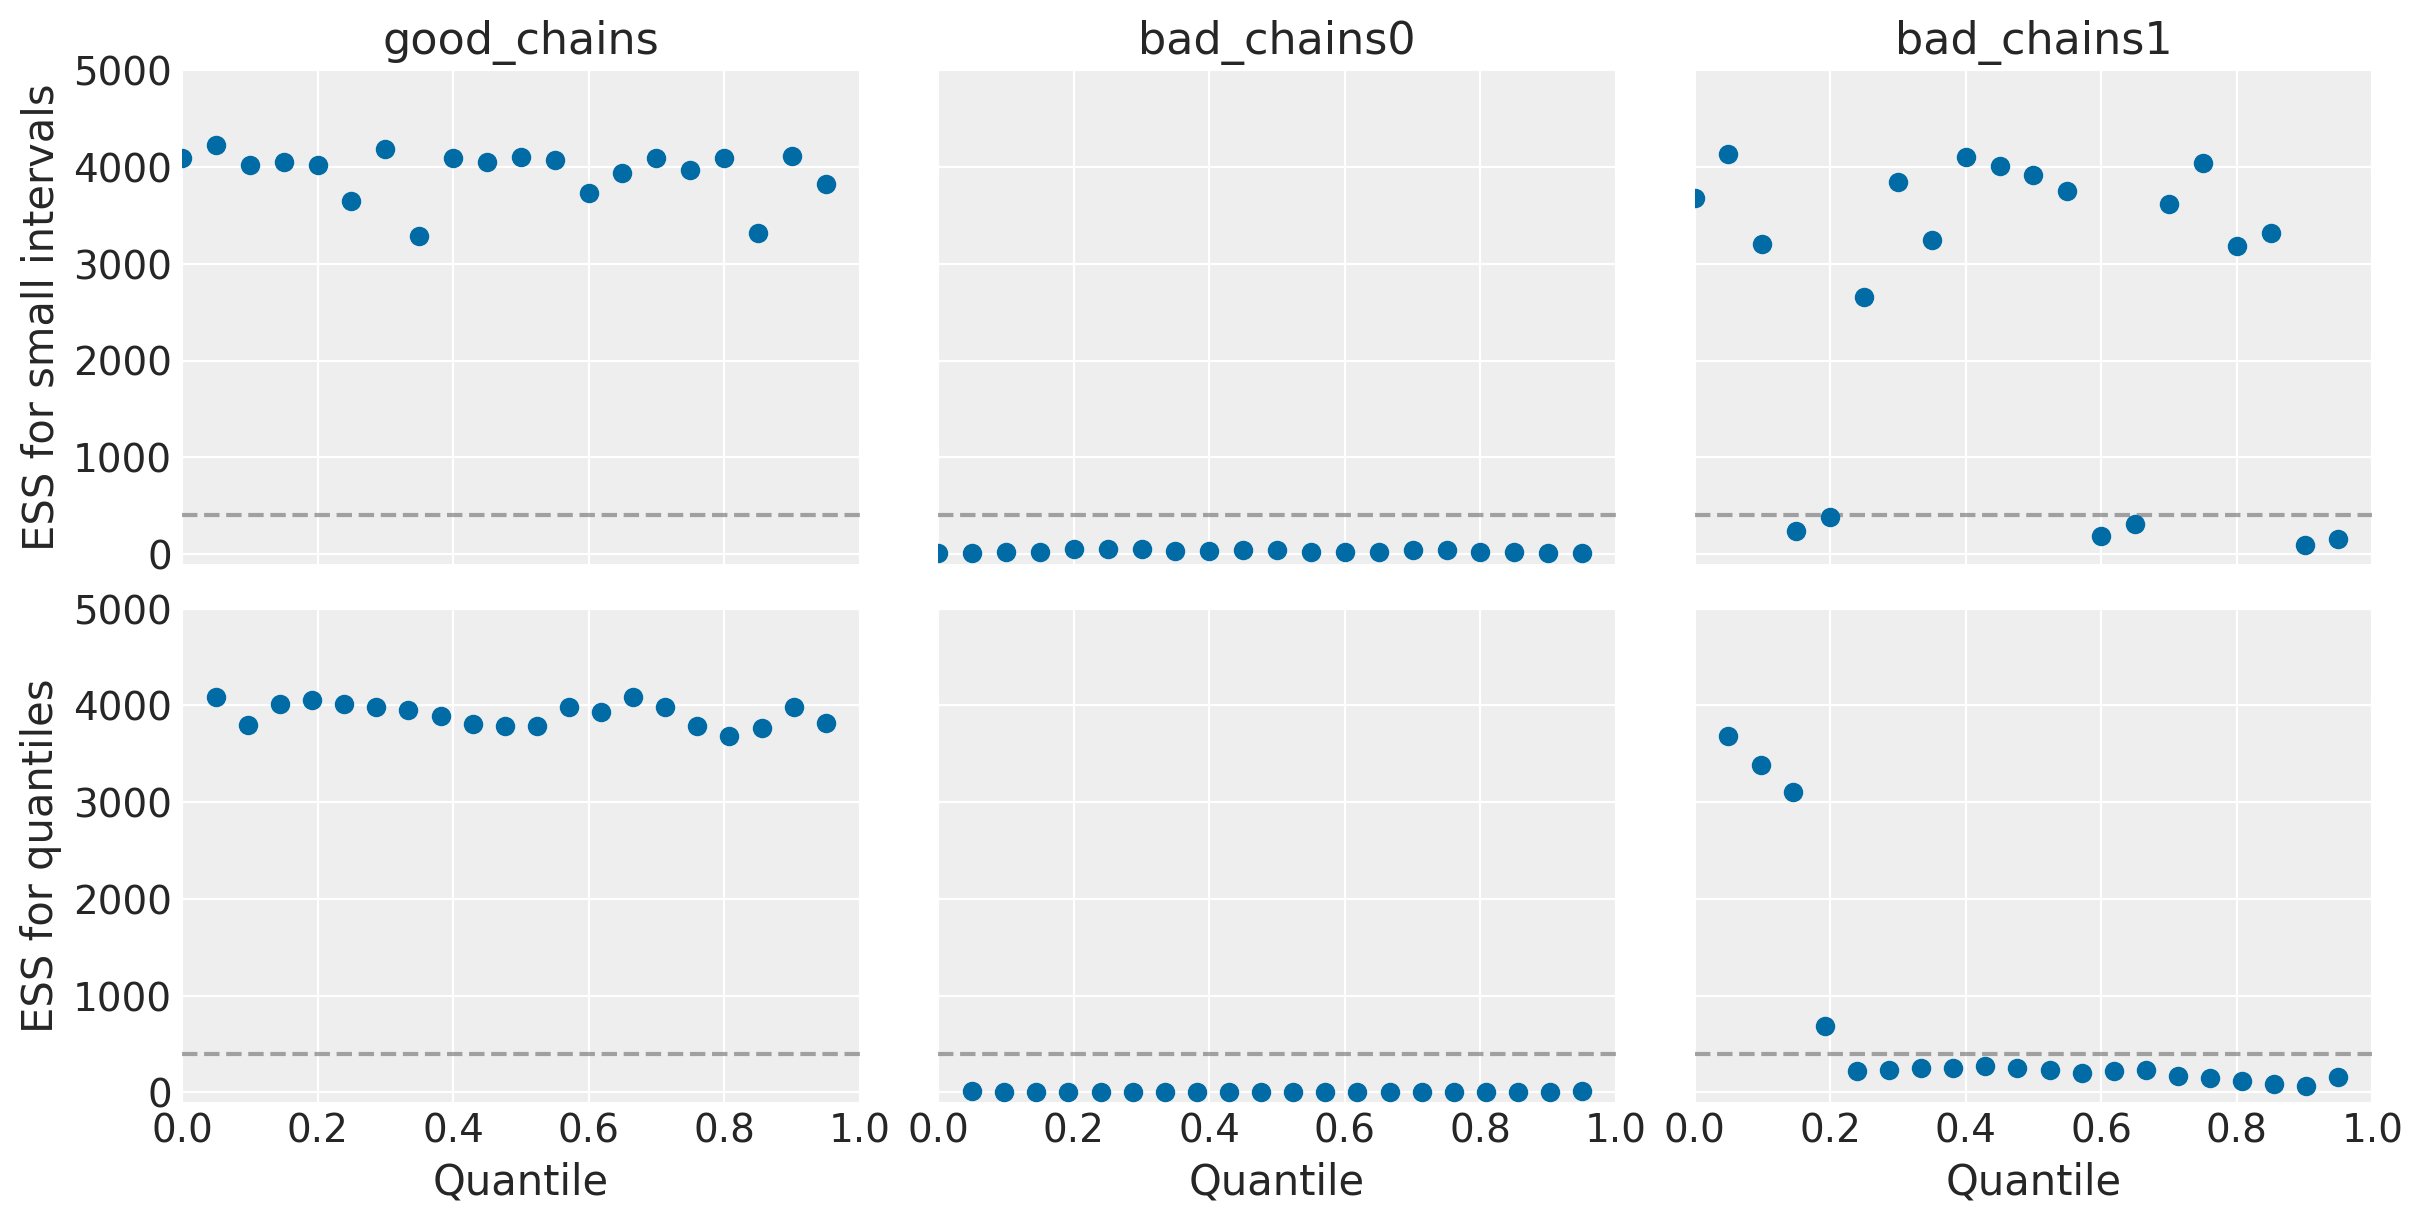

In [7]:
_, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:, 1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000)


## Autocorrelazione

Normalmente un algoritmo MCMC genera catene di Markov di campioni ognuno dei quali è autocorrelato a quelli generati immediatamente prima e dopo di lui. Conseguentemente campioni successivi non sono indipendenti ma formano una catena di Markov con un certo grado di correlazione. Il valore $\theta^{(i)}$ tende ad essere più simile al valore $\theta^{(i-1)}$ che al valore $\theta^{(i-2)}$, o al valore $\theta^{(i-3)}$, eccetera. Una misura di questo è fornita dall'autocorrelazione tra i valori consecutivi della catena.

Il correlogramma mostra l'autocorrelazione in funzione di ritardi da 0 a 20. L'autocorrelazione di lag 0 è naturalmente 1 -- misura la correlazione tra un valore della catena di Markov e se stesso. Se l'autocorrelazione di lag 1 non è troppo grande, indicando una correlazione moderata tra i valori della catena che distano di solo 1 passo l'uno dall'altro, e, successivamente, diminuisce rapidamente, questo indica che la catena di Markov costituisce una buona approssimazione di un campione casuale di $p(\theta \mid y)$.

Una (famiglia di) catene di Markov si dice *rapidly mixing* se mostra un comportamento simile a quello di un campione indipendente: i valori delle catene si addensano nell'intervallo dei valori più plausibili della distribuzione a posteriori; l'autocorrelazione tra i valori della catena diminuisce rapidamente; il rapporto campionario effettivo è ragionevolmente grande. Le catene che non sono *rapidly mixing* non godono delle caratteristiche di un campione indipendente: le catene non si addensano nell'intervallo dei valori più plausibili della distribuzione a posteriori; l'autocorrelazione tra i valori della catena diminuisce molto lentamente; il rapporto campionario effettivo è piccolo.

In presenza di catene di Markov non *rapidly mixing* sono possibili due rimedi.

-   Aumentare il numero di iterazioni. Anche una catena non *rapidly mixing* può produrre eventualmente una buona approssimazione della distribuzione a posteriori se il numero di iterazioni è sufficientemente grande.
-   *Thinning*. Per esempio, se la catena di Markov è costituita da 16000 valori di $\theta$, potremmo decidere di conservare solo ogni secondo valore e ignorare gli altri valori: $\{\theta^{(2)}, \theta^{(4)}, \theta^{(6)}, \dots, \theta^{(16000)}\}$. Oppure, potremmo decidere di conservare ogni decimo valore: $\{\theta^{(10)}, \theta^{(20)}, \theta^{(30)}, \dots, \theta^{(16000)}\}$. Scartando i campioni intermedi, è possibile rimuovere le forti correlazioni che sono presenti nel caso di lag più piccoli.

Un esempio è il seguente {cite:p}`martin2022bayesian`.

array([<AxesSubplot: title={'center': 'good_chains'}>,
       <AxesSubplot: title={'center': 'bad_chains0'}>,
       <AxesSubplot: title={'center': 'bad_chains1'}>], dtype=object)

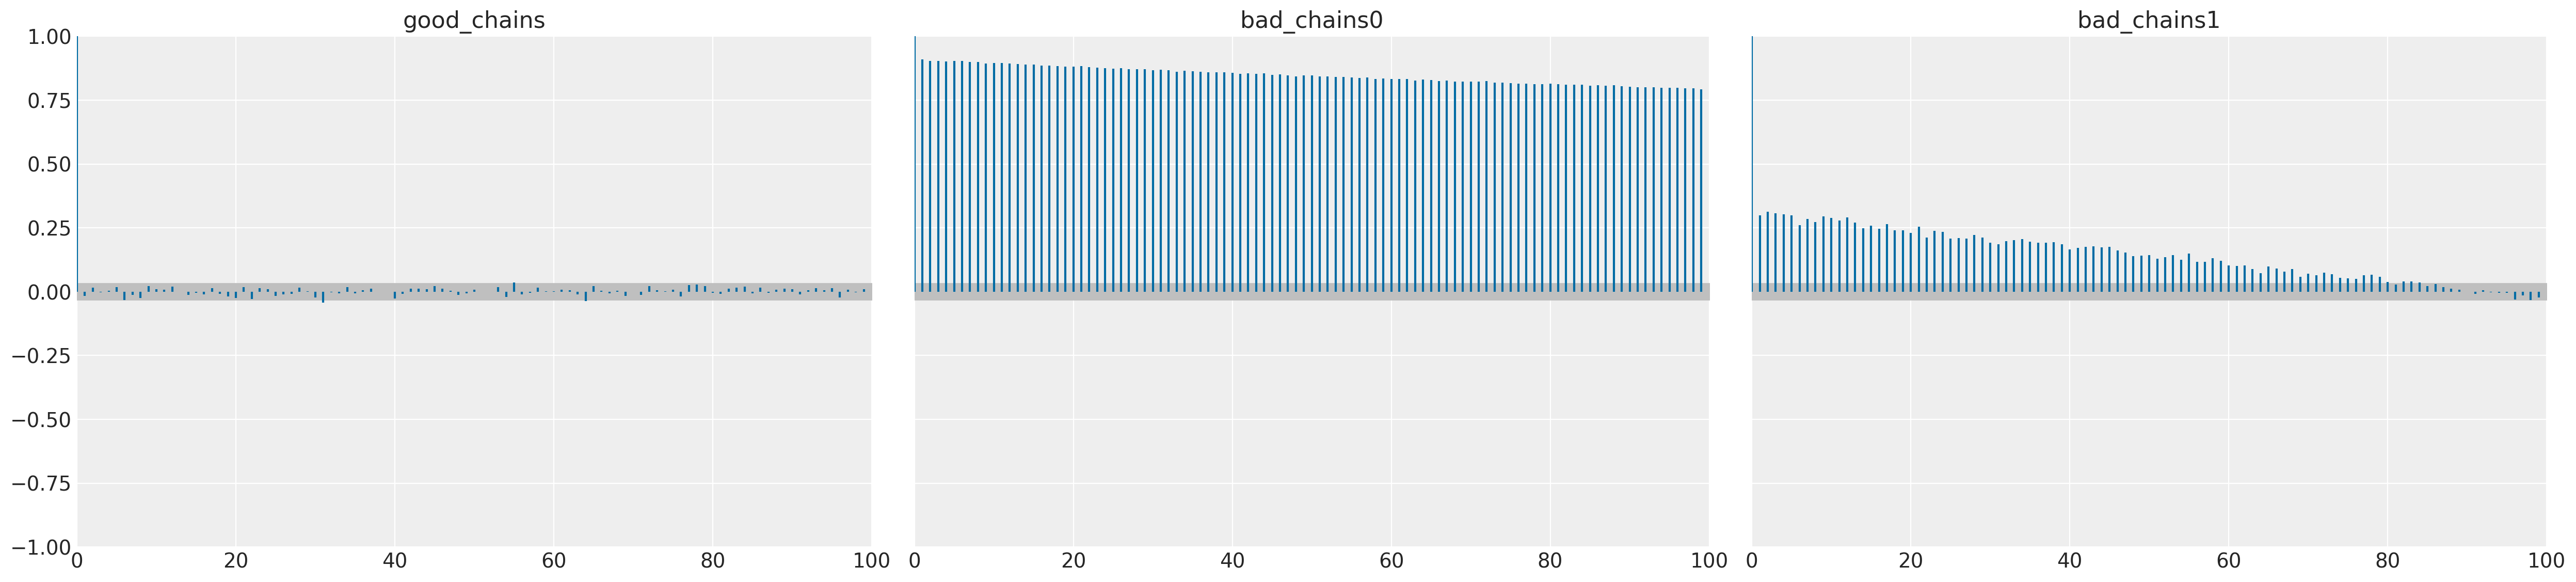

In [8]:
_ = az.plot_autocorr(chains, combined=True)

## Statistica $\hat{R}$

In precedenza abbiamo detto che non solo è necessario che ogni singola catena sia stazionaria, ma è anche necessario che le diverse catene siano coerenti tra loro. La statistica $\hat{R}$ affronta questo problema calcolando il rapporto tra la varianza tra le catene markoviane e la varianza entro le catene. In una situazione ottimale $\hat{R} = 1$; se $\hat{R}$ è lontano da 1 questo vuol dire che non è ancora stata raggiunta la convergenza. 

**Interpretazione:**  in maniera euristica possiamo dire che, se $\hat{R}$ supera la soglia di 1.05, questo viene interpretato come evidenza che le diverse catene parallele non producono approssimazioni coerenti della distribuzione a posteriori: la simulazione è instabile.

In [11]:
_ = az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.9999
    bad_chains0  float64 2.4
    bad_chains1  float64 1.015

Nell'esempio di {cite:t}`martin2022bayesian` vediamo come $\hat{R}$ è in grado di distinguere tra le buone e le cattive catene MCMC. Mentre `bad_chains0` ha valori $\hat{R}$ totalmente inadeguati, `bad_chains1` tende ad avere valori accettabili.

## Diagnostica di convergenza di Geweke

La statistica diagnostica di convergenza di Geweke è basata su un test per l'uguaglianza delle medie della prima e dell'ultima parte di una catena di Markov (di default il primo 10% e l'ultimo 50% della catena). Se i due campioni sono estratti dalla distribuzione stazionaria della catena, le due medie sono statisticamente uguali e la statistica di Geweke ha una distribuzione asintotica Normale standardizzata.

**Interpretazione:** la statistica di Geweke è uguale a zero quando le medie delle due porzioni della catena di Markov sono uguali; valori maggiori di $\mid 2 \mid$ suggeriscono che la catena non ha ancora raggiunto una distribuzione stazionaria.


## Errore standard di Monte Carlo

Quando utilizziamo i metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando il posteriore con un numero finito di campioni. Possiamo stimare la quantità di questo tipo di errore mediante la statistica *errore standard di Monte Carlo* (MCSE). Il MCSE è definitp come la deviazione standard delle catene MCMC divisa per la loro numerosità campionaria effettiva (ESS). Il MCSE ci fornisce dunque un'indicazione quantitativa di quanto è grande sia il "rumore" della stima.

Per l'esempio di {cite:t}`martin2022bayesian` otteniamo i valori seguenti.

In [12]:
_ = az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002533
    bad_chains0  float64 0.1076
    bad_chains1  float64 0.01521

array([<AxesSubplot: title={'center': 'good_chains'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       <AxesSubplot: title={'center': 'bad_chains0'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       <AxesSubplot: title={'center': 'bad_chains1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
      dtype=object)

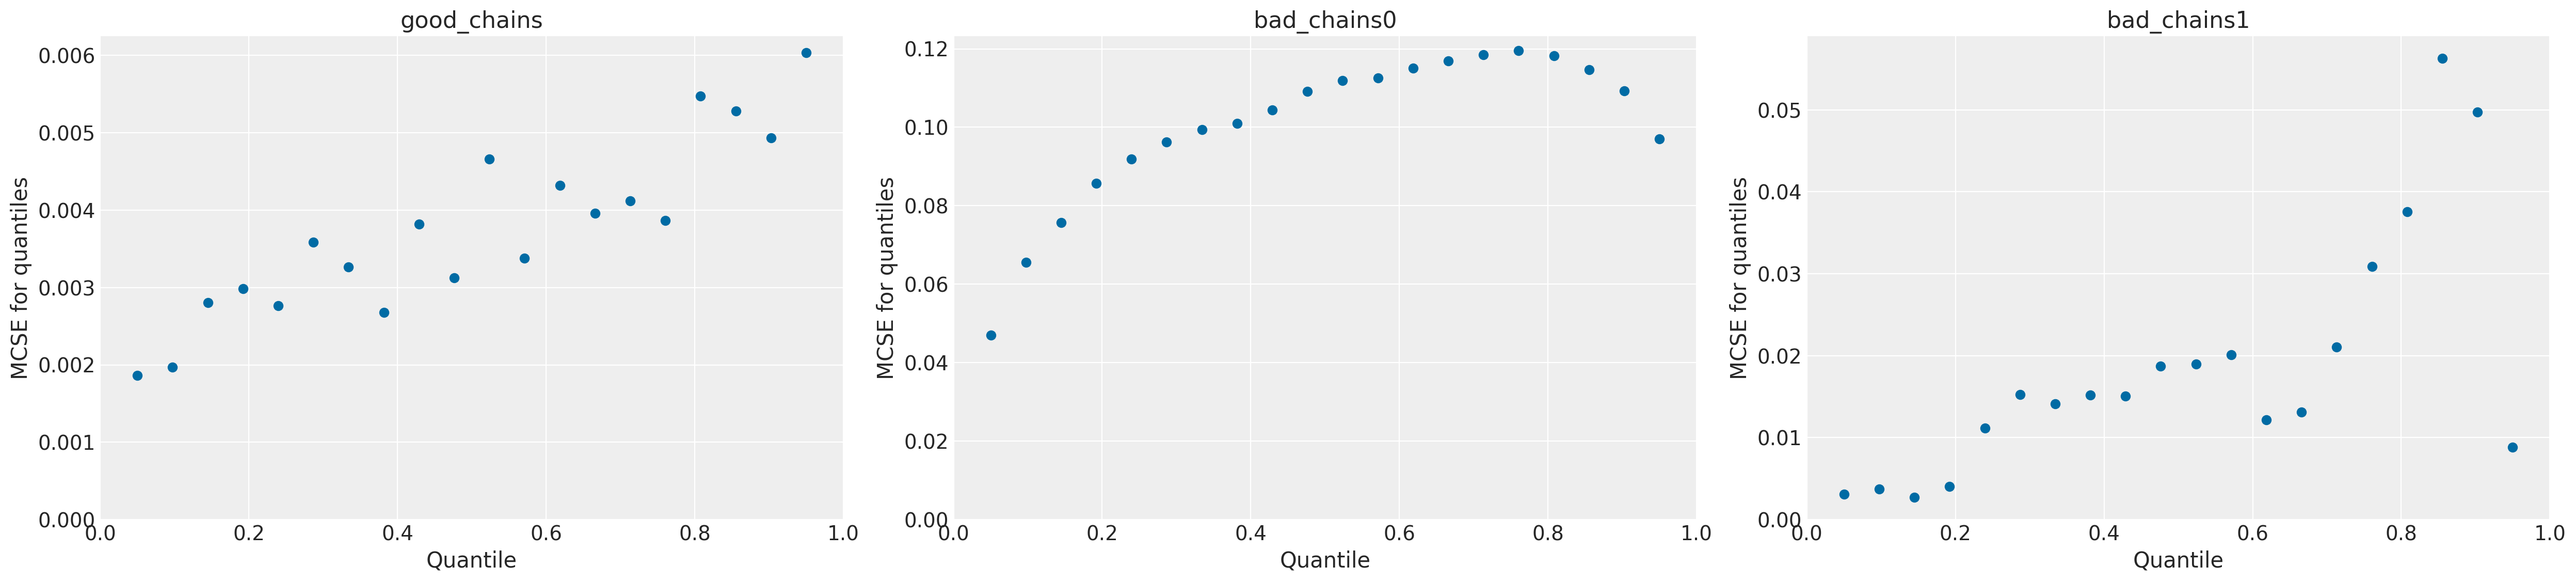

In [13]:
_ = az.plot_mcse(chains)

## Rank Plots

I rank plots forniscono un'altra diagnostica visiva che possiamo usare per confrontare il comportamento del campionamento sia all'interno che tra le catene. I rank plots sono degli istogrammi dei ranghi delle catene. I ranghi vengono calcolati combinando tutte le catene; poi i risultati vengono mostrati separatamente per ogni catena. Se tutte le catene hanno come target la stessa distribuzione, ci aspettiamo che i ranghi abbiano una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica una buon mixing delle catene.

Questo è l'esempio di {cite:t}`martin2022bayesian`:

array([<AxesSubplot: title={'center': 'good_chains'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot: title={'center': 'bad_chains0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <AxesSubplot: title={'center': 'bad_chains1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

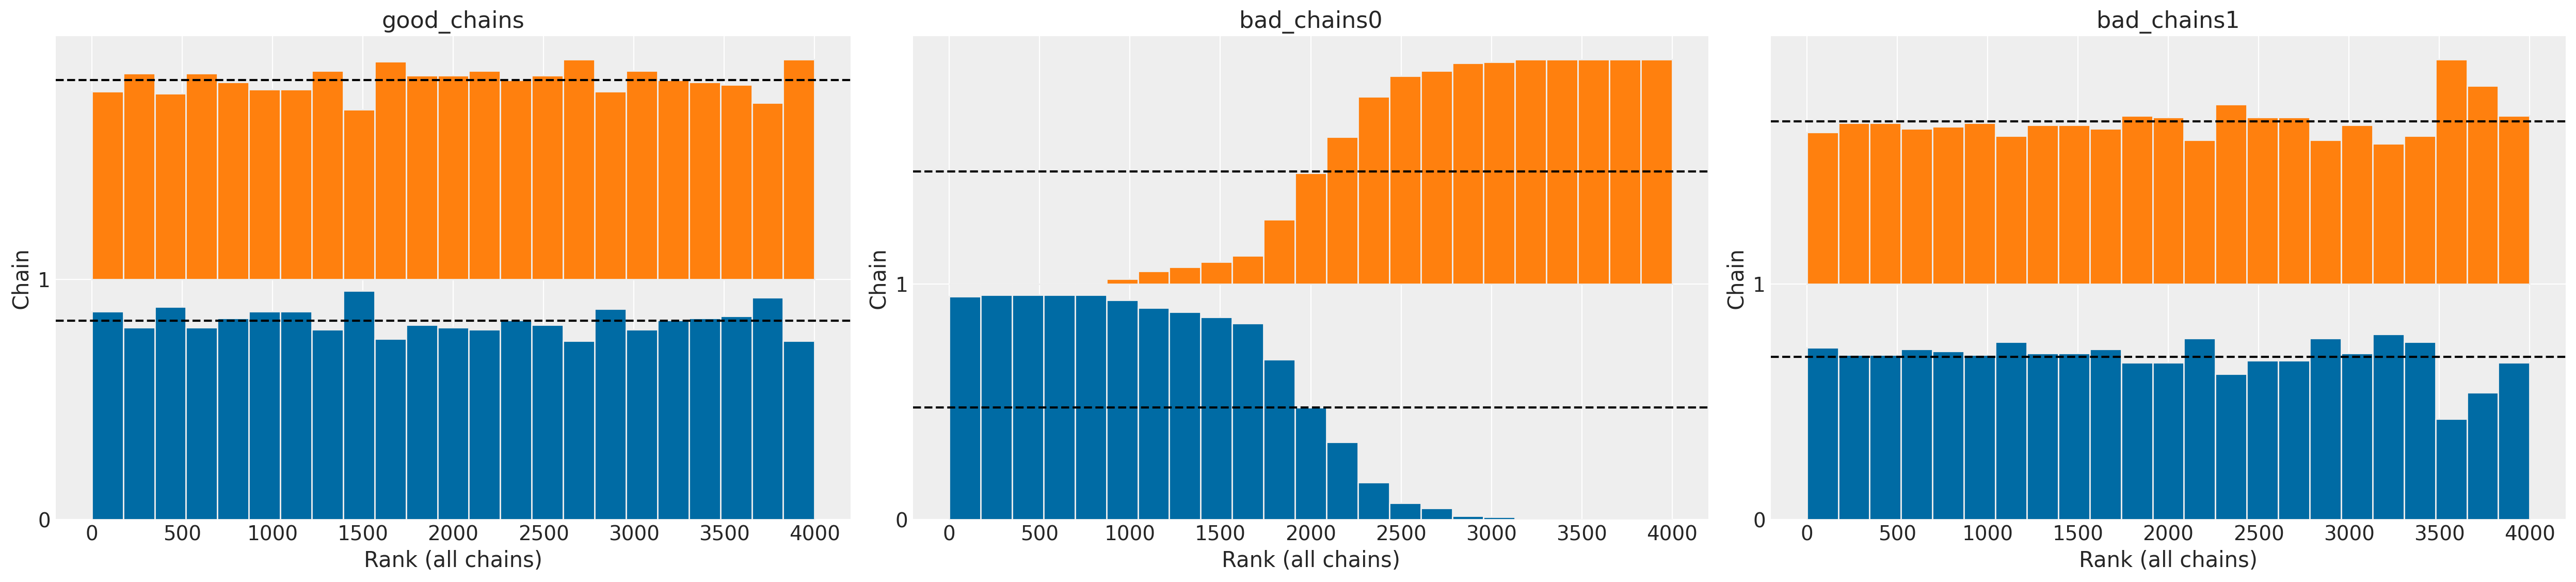

In [15]:
_ = az.plot_rank(chains, kind="bars")

Una rappresentazione alternativa (con dei segmenti verticali al posto delle barre) è la seguente:

array([<AxesSubplot: title={'center': 'good_chains'}, xlabel='Rank (all chains)'>,
       <AxesSubplot: title={'center': 'bad_chains0'}, xlabel='Rank (all chains)'>,
       <AxesSubplot: title={'center': 'bad_chains1'}, xlabel='Rank (all chains)'>],
      dtype=object)

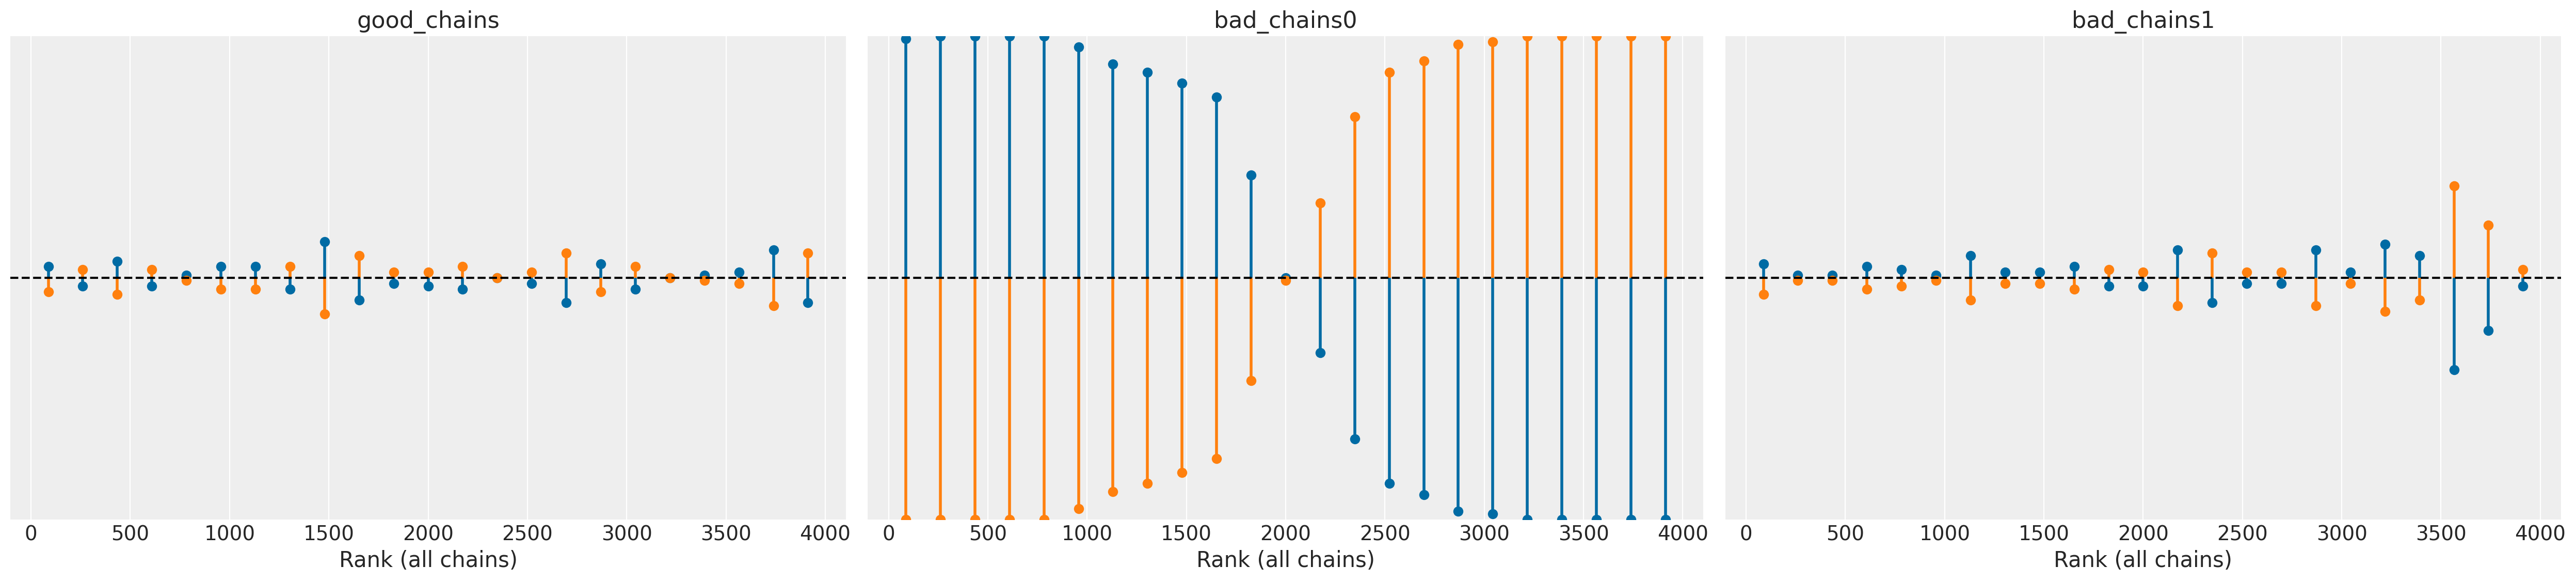

In [16]:
_ = az.plot_rank(chains, kind="vlines")

## Divergenze

Finora abbiamo diagnosticato il funzionamento di un campionatore studiando i campioni generati. Un altro modo per eseguire una diagnostica è monitorare il comportamento dei meccanismi interni del metodo di campionamento. Un esempio importante di tale diagnostica è il concetto di *divergenza* (*divergence*) presente in alcuni metodi Hamiltoniani Monte Carlo (HMC). Le divergenze forniscono una diagnostica molto sensibile e si accompagnano alla diagnostica che abbiamo visto nelle sezioni precedenti.

Fornisco qui un'illustrazione del concetto di divergenza facendo riferimento ad un modello presentato da {cite:t}`martin2022bayesian`. Questo modello intende stimare il parametro $\theta_2$ che segue una distribuzione uniforme nell'intervallo $[-\theta_1, \theta_1]$ e $\theta_1$ è campionato da una distribuzione normale. Quando $\theta_1$ è grande, $\theta_2$ seguirà una distribuzione uniforme che copre un'ampia gamma e quando $\theta_1$ è prossimo allo zero, anche la larghezza della distribuzione uniforme campionata da $\theta_2$ si avvicina allo zero. Ci vengono presentate tre versioni di questo modello. Senza entrare nei dettagli, la cosa importante è che il modello 0 è un modello sbagliato e, nella figura seguente, le *divergent transitions* sono indicate in blu. Si noti che ce ne sono tantissime! 

```{image} images/divergences_pair.png
:height: 300px
:align: center
```

Il modello 1 è molto migliorato rispetto al precedente e questo si nota osservando, nella figura, che c'è un piccolo numero di *divergent transitions*. Il modello 1bis, infine, è adeguato, in quanto non è presente alcuna *divergent transition*. Per una discussione tecnica delle divergenze, si veda, ad esempio, [Stan Reference Manual](https://mc-stan.org/docs/reference-manual/divergent-transitions.html).

Quando si usa un campionatore basato su Hamiltonian Monte Carlo (HMC), il numero di *divergent transitions* è sempre mostrato in output (dovrebbe essere zero).

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w